# Practica 3
**Tecnologías de Lenguaje Natural**

*Luis Fernando Rodríguez Domínguez*

5BV1

*Ingeniería en Inteligencia Artificial*

Fecha última de modificación: 4 de mayo del 2025

**Funcionalidad General:**  
Este programa implementa diversas técnicas de extracción automática de texto en Python, específicamente para la identificación de palabras clave y el resumen automático de texto. Utilizando el libro "Frankenstein", se extraen y procesan las tres primeras cartas para generar resúmenes extractivos mediante varios algoritmos. El programa incluye:
- Extracción y normalización de textos
- Implementación de diferentes métodos de resumen automático extractivo
- Medición de tiempos de ejecución para cada algoritmo
- Comparación de los resultados obtenidos

La única entrada necesaria es un archivo de texto (frankenstein.txt) que contiene las cartas a procesar.

**Listado y Descripción de Funciones:**

1. **Extracción y Procesamiento de Texto:**
   - `extraer_cartas_individuales(filepath)`: Extrae las tres primeras cartas del archivo de texto.
   - `normalizar_texto(texto)`: Aplica un proceso de normalización que incluye tokenización, eliminación de stopwords y conversión a minúsculas.

2. **Algoritmos de Resumen Automático:**
   - `resumen_tfidf(texto_original, texto_normalizado, n=4)`: Genera resumen basado en TF-IDF.
   - `resumen_frecuencia(texto_original, texto_normalizado, n=4)`: Genera resumen basado en frecuencia de palabras.
   - `resumen_rake(texto_original, n=4)`: Utiliza el algoritmo RAKE para extraer frases clave.
   - `resumen_textrank_sumy(texto, n=4)`: Implementa el algoritmo TextRank para generar resúmenes.
   - `resumen_lsa_sumy(texto, n=4)`: Utiliza LSA (Latent Semantic Analysis) para resumir texto.
   - `resumen_bert(texto, n=4)`: Emplea modelos BERT para la generación de resúmenes extractivos.

3. **Medición y Análisis:**
   - Cada función de resumen incluye medición de tiempo de ejecución.
   - Se implementa un análisis comparativo de los resultados de cada algoritmo.

In [1]:
!pip install rake_nltk
!pip install sumy
!pip install bert-extractive-summarizer
!pip install transformers
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import nltk
import string
import time
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK resources
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# RAKE for keyword extraction
from rake_nltk import Rake

# Sumy for TextRank and LSA
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

# BERT for extractive summarization
from summarizer import Summarizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1. Generación de cuerpo de documentos

Para trabajar con el texto de Frankenstein, se han extraído tres cartas (Carta 1, 2 y 3) en un documento TXT denominado `frank.txt`. El proceso de extracción se basa en la búsqueda de la etiqueta "Letter X", que identifica el encabezado de cada carta.


In [3]:
def extraer_cartas_individuales(filepath):
    """
    Extrae cartas individuales de un archivo de texto, separándolas por la palabra clave 'Letter' seguida de un número.

    Args:
        filepath (str): Ruta al archivo que contiene las cartas.

    Returns:
        tuple: Tres cadenas de texto correspondientes a las tres primeras cartas.
    """
    print(f"[INFO] Iniciando extracción de cartas desde: {filepath}")

    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            texto = file.read()

        # Separar por la palabra clave 'Letter ' seguida de un número
        partes = texto.split("Letter ")

        # Filtramos solo las partes que contienen cartas (evita encabezado si lo hay)
        cartas_crudas = ["Letter " + parte.strip() for parte in partes if parte.strip().startswith(("1", "2", "3"))]

        # Extraer individualmente si hay al menos 3 cartas
        carta1 = cartas_crudas[0] if len(cartas_crudas) >= 1 else ""
        carta2 = cartas_crudas[1] if len(cartas_crudas) >= 2 else ""
        carta3 = cartas_crudas[2] if len(cartas_crudas) >= 3 else ""

        print(f"[SUCCESS] Se extrajeron {len(cartas_crudas)} cartas correctamente")
        return carta1, carta2, carta3

    except Exception as e:
        print(f"[ERROR] Error al extraer cartas: {str(e)}")
        return "", "", ""

In [4]:
carta1, carta2, carta3 = extraer_cartas_individuales('/content/frankenstein.txt')

# Mostramos las primeras 200 caracteres de cada carta para verificar
print("\n=== FRAGMENTO DE LA CARTA 1 ===")
print(carta1)
print("\n=== FRAGMENTO DE LA CARTA 2 ===")
print(carta2)
print("\n=== FRAGMENTO DE LA CARTA 3 ===")
print(carta3)

[INFO] Iniciando extracción de cartas desde: /content/frankenstein.txt
[SUCCESS] Se extrajeron 3 cartas correctamente

=== FRAGMENTO DE LA CARTA 1 ===
Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings. I arrived here yesterday, and my first task is to assure
my dear sister of my welfare and increasing confidence in the success
of my undertaking.

I am already far north of London, and as I walk in the streets of
Petersburgh, I feel a cold northern breeze play upon my cheeks, which
braces my nerves and fills me with delight. Do you understand this
feeling? This breeze, which has travelled from the regions towards
which I am advancing, gives me a foretaste of those icy climes.
Inspirited by this wind of promise, my daydreams become more fervent
and vivid. I try in vain to be persuaded that the pole is the seat of
frost and 

## 2. Normalización de textos

El proceso de normalización facilita la extracción de palabras clave y la generación de resúmenes automáticos mediante la reducción de ruido en los datos. Este paso es crucial para mejorar la calidad de los resúmenes generados posteriormente.

En esta implementación, aplicamos:
1. Tokenización del texto en oraciones
2. Conversión a minúsculas
3. Eliminación de stopwords (palabras comunes como "the", "a", "is", etc.)
4. Filtrado de caracteres no alfanuméricos

In [5]:
def normalizar_texto(texto):
    """
    Normaliza un texto tokenizándolo en oraciones, eliminando puntuaciones y stopwords.

    Args:
        texto (str): Texto a normalizar.

    Returns:
        tuple: Oraciones originales y sus versiones normalizadas.
    """
    print(f"[INFO] Iniciando normalización de texto ({len(texto)} caracteres)")
    start_time = time.time()

    # Definir stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenizar en oraciones
    oraciones = sent_tokenize(texto)

    texto_normalizado = []
    for oracion in oraciones:
        # Tokenizar, convertir a minúsculas y eliminar stopwords
        palabras = word_tokenize(oracion.lower())
        palabras_limpias = [w for w in palabras if w.isalnum() and w not in stop_words]
        texto_normalizado.append(" ".join(palabras_limpias))

    tiempo_ejecucion = time.time() - start_time
    print(f"[SUCCESS] Normalización completada en {tiempo_ejecucion:.4f} segundos. {len(oraciones)} oraciones procesadas.")

    return oraciones, texto_normalizado

In [6]:
oraciones1, carta1_norm = normalizar_texto(carta1)
oraciones2, carta2_norm = normalizar_texto(carta2)
oraciones3, carta3_norm = normalizar_texto(carta3)

# Mostramos ejemplos de la normalización
print("\n=== EJEMPLOS DE NORMALIZACIÓN (CARTA 1) ===")
for i in range(min(3, len(oraciones1))):
    print(f"\nOración original: {oraciones1[i]}")
    print(f"Oración normalizada: {carta1_norm[i]}")

[INFO] Iniciando normalización de texto (6848 caracteres)
[SUCCESS] Normalización completada en 0.0723 segundos. 49 oraciones procesadas.
[INFO] Iniciando normalización de texto (7358 caracteres)
[SUCCESS] Normalización completada en 0.0143 segundos. 49 oraciones procesadas.
[INFO] Iniciando normalización de texto (1707 caracteres)
[SUCCESS] Normalización completada en 0.0046 segundos. 19 oraciones procesadas.

=== EJEMPLOS DE NORMALIZACIÓN (CARTA 1) ===

Oración original: Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.
Oración normalizada: letter 1 saville petersburgh 11th

Oración original: You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings.
Oración normalizada: rejoice hear disaster accompanied commencement enterprise regarded evil forebodings

Oración original: I arrived here yesterday, and my first task is to assure
my dear sister of my welfare and increasing confid

## 3. Resumen automático extractivo de texto

Se implementan seis técnicas diferentes de resumen automático extractivo, cada una con enfoques y características distintas para la selección de frases representativas.


### 3.1 Método TF-IDF

El método TF-IDF (Term Frequency-Inverse Document Frequency) asigna pesos a los términos basados en su frecuencia en un documento específico y en la colección de documentos. Las oraciones con mayor puntuación TF-IDF se consideran más representativas del texto.


In [7]:
def resumen_tfidf(texto_original, texto_normalizado, n=4):
    """
    Genera un resumen basado en TF-IDF, seleccionando las oraciones con mayor puntuación.

    Args:
        texto_original (list): Lista de oraciones originales.
        texto_normalizado (list): Lista de oraciones normalizadas.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen TF-IDF ({n} oraciones)")
    start = time.time()

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texto_normalizado)
    scores = np.asarray(tfidf_matrix.sum(axis=1)).ravel()
    top_idx = scores.argsort()[-n:][::-1]
    resumen = [f"- {texto_original[i]}" for i in sorted(top_idx)]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen TF-IDF completado en {tiempo_ejecucion:.4f} segundos")
    return resumen, tiempo_ejecucion

In [8]:
print("===== RESUMEN TF-IDF: CARTA 1 =====")
resumen_tfidf_carta1, tiempo_tfidf_1 = resumen_tfidf(oraciones1, carta1_norm)
for oracion in resumen_tfidf_carta1:
    print(oracion)

print("\n===== RESUMEN TF-IDF: CARTA 2 =====")
resumen_tfidf_carta2, tiempo_tfidf_2 = resumen_tfidf(oraciones2, carta2_norm)
for oracion in resumen_tfidf_carta2:
    print(oracion)

print("\n===== RESUMEN TF-IDF: CARTA 3 =====")
resumen_tfidf_carta3, tiempo_tfidf_3 = resumen_tfidf(oraciones3, carta3_norm)
for oracion in resumen_tfidf_carta3:
    print(oracion)

===== RESUMEN TF-IDF: CARTA 1 =====
[INFO] Iniciando resumen TF-IDF (4 oraciones)
[SUCCESS] Resumen TF-IDF completado en 0.0066 segundos
- There—for with your leave, my sister, I will put
some trust in preceding navigators—there snow and frost are banished;
and, sailing over a calm sea, we may be wafted to a land surpassing in
wonders and in beauty every region hitherto discovered on the habitable
globe.
- But supposing all these conjectures to be false, you
cannot contest the inestimable benefit which I shall confer on all
mankind, to the last generation, by discovering a passage near the pole
to those countries, to reach which at present so many months are
requisite; or by ascertaining the secret of the magnet, which, if at
all possible, can only be effected by an undertaking such as mine.
- These reflections have dispelled the agitation with which I began my
letter, and I feel my heart glow with an enthusiasm which elevates me
to heaven, for nothing contributes so much to tranquilli

### 3.2 Método de Frecuencia de Palabras Normalizada

Este enfoque identifica las frases clave seleccionando las palabras más frecuentes en el texto, ajustadas según normalización para evitar sesgos por palabras repetitivas.


In [9]:
def resumen_frecuencia(texto_original, texto_normalizado, n=4):
    """
    Genera un resumen basado en frecuencia de palabras, seleccionando oraciones con palabras más frecuentes.

    Args:
        texto_original (list): Lista de oraciones originales.
        texto_normalizado (list): Lista de oraciones normalizadas.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen por Frecuencia de Palabras ({n} oraciones)")
    start = time.time()

    freq = Counter(" ".join(texto_normalizado).split())
    oracion_scores = []
    for i, oracion in enumerate(texto_normalizado):
        score = sum(freq[word] for word in oracion.split())
        oracion_scores.append((i, score))
    top_idx = sorted(oracion_scores, key=lambda x: x[1], reverse=True)[:n]
    resumen = [f"- {texto_original[i]}" for i, _ in sorted(top_idx)]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen por Frecuencia completado en {tiempo_ejecucion:.4f} segundos")
    return resumen, tiempo_ejecucion

In [10]:
print("===== RESUMEN POR FRECUENCIA: CARTA 1 =====")
resumen_freq_carta1, tiempo_freq_1 = resumen_frecuencia(oraciones1, carta1_norm)
for oracion in resumen_freq_carta1:
    print(oracion)

print("\n===== RESUMEN POR FRECUENCIA: CARTA 2 =====")
resumen_freq_carta2, tiempo_freq_2 = resumen_frecuencia(oraciones2, carta2_norm)
for oracion in resumen_freq_carta2:
    print(oracion)

print("\n===== RESUMEN POR FRECUENCIA: CARTA 3 =====")
resumen_freq_carta3, tiempo_freq_3 = resumen_frecuencia(oraciones3, carta3_norm)
for oracion in resumen_freq_carta3:
    print(oracion)

===== RESUMEN POR FRECUENCIA: CARTA 1 =====
[INFO] Iniciando resumen por Frecuencia de Palabras (4 oraciones)
[SUCCESS] Resumen por Frecuencia completado en 0.0014 segundos
- There—for with your leave, my sister, I will put
some trust in preceding navigators—there snow and frost are banished;
and, sailing over a calm sea, we may be wafted to a land surpassing in
wonders and in beauty every region hitherto discovered on the habitable
globe.
- I
may there discover the wondrous power which attracts the needle and may
regulate a thousand celestial observations that require only this
voyage to render their seeming eccentricities consistent for ever.
- But supposing all these conjectures to be false, you
cannot contest the inestimable benefit which I shall confer on all
mankind, to the last generation, by discovering a passage near the pole
to those countries, to reach which at present so many months are
requisite; or by ascertaining the secret of the magnet, which, if at
all possible, can o

### 3.3 Método RAKE (Rapid Automatic Keyword Extraction)

RAKE es un algoritmo que utiliza patrones de palabras y la frecuencia de co-ocurrencia para extraer frases clave de manera rápida. No requiere un corpus entrenado, lo que lo hace muy flexible para diferentes dominios.


In [11]:
def resumen_rake(texto_original, n=4):
    """
    Genera un resumen usando RAKE (Rapid Automatic Keyword Extraction).

    Args:
        texto_original (list): Lista de oraciones originales.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen RAKE ({n} oraciones)")
    start = time.time()

    r = Rake()
    r.extract_keywords_from_text(" ".join(texto_original))
    key_phrases = r.get_ranked_phrases_with_scores()

    oracion_scores = []
    for i, oracion in enumerate(texto_original):
        score = sum(score for score, phrase in key_phrases if phrase in oracion.lower())
        oracion_scores.append((i, score))

    top_idx = sorted(oracion_scores, key=lambda x: x[1], reverse=True)[:n]
    resumen = [f"- {texto_original[i]}" for i, _ in sorted(top_idx)]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen RAKE completado en {tiempo_ejecucion:.4f} segundos")
    return resumen, tiempo_ejecucion

In [12]:
print("===== RESUMEN RAKE: CARTA 1 =====")
resumen_rake_carta1, tiempo_rake_1 = resumen_rake(oraciones1)
for oracion in resumen_rake_carta1:
    print(oracion)

print("\n===== RESUMEN RAKE: CARTA 2 =====")
resumen_rake_carta2, tiempo_rake_2 = resumen_rake(oraciones2)
for oracion in resumen_rake_carta2:
    print(oracion)

print("\n===== RESUMEN RAKE: CARTA 3 =====")
resumen_rake_carta3, tiempo_rake_3 = resumen_rake(oraciones3)
for oracion in resumen_rake_carta3:
    print(oracion)

===== RESUMEN RAKE: CARTA 1 =====
[INFO] Iniciando resumen RAKE (4 oraciones)
[SUCCESS] Resumen RAKE completado en 0.0356 segundos
- I am already far north of London, and as I walk in the streets of
Petersburgh, I feel a cold northern breeze play upon my cheeks, which
braces my nerves and fills me with delight.
- There—for with your leave, my sister, I will put
some trust in preceding navigators—there snow and frost are banished;
and, sailing over a calm sea, we may be wafted to a land surpassing in
wonders and in beauty every region hitherto discovered on the habitable
globe.
- But supposing all these conjectures to be false, you
cannot contest the inestimable benefit which I shall confer on all
mankind, to the last generation, by discovering a passage near the pole
to those countries, to reach which at present so many months are
requisite; or by ascertaining the secret of the magnet, which, if at
all possible, can only be effected by an undertaking such as mine.
- I
accompanied the w

### 3.4 Método TextRank (usando biblioteca Sumy)

TextRank es un algoritmo basado en grafos similar a PageRank. Construye un grafo donde los nodos son oraciones y los bordes representan su similitud, luego utiliza un algoritmo de clasificación para identificar las oraciones más relevantes.


In [13]:
def resumen_textrank_sumy(texto, n=4):
    """
    Genera un resumen usando TextRank a través de la biblioteca Sumy.

    Args:
        texto (str): Texto completo a resumir.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen TextRank (Sumy) ({n} oraciones)")
    start = time.time()

    parser = PlaintextParser.from_string(texto, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    resumen = summarizer(parser.document, n)
    resultado = [f"- {str(oracion)}" for oracion in resumen]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen TextRank (Sumy) completado en {tiempo_ejecucion:.4f} segundos")
    return resultado, tiempo_ejecucion

In [14]:
print("===== RESUMEN TEXTRANK: CARTA 1 =====")
resumen_textrank_carta1, tiempo_textrank_1 = resumen_textrank_sumy(" ".join(oraciones1))
for oracion in resumen_textrank_carta1:
    print(oracion)

print("\n===== RESUMEN TEXTRANK: CARTA 2 =====")
resumen_textrank_carta2, tiempo_textrank_2 = resumen_textrank_sumy(" ".join(oraciones2))
for oracion in resumen_textrank_carta2:
    print(oracion)

print("\n===== RESUMEN TEXTRANK: CARTA 3 =====")
resumen_textrank_carta3, tiempo_textrank_3 = resumen_textrank_sumy(" ".join(oraciones3))
for oracion in resumen_textrank_carta3:
    print(oracion)

===== RESUMEN TEXTRANK: CARTA 1 =====
[INFO] Iniciando resumen TextRank (Sumy) (4 oraciones)
[SUCCESS] Resumen TextRank (Sumy) completado en 0.2081 segundos
- But supposing all these conjectures to be false, you cannot contest the inestimable benefit which I shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite; or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.
- These reflections have dispelled the agitation with which I began my letter, and I feel my heart glow with an enthusiasm which elevates me to heaven, for nothing contributes so much to tranquillise the mind as a steady purpose—a point on which the soul may fix its intellectual eye.
- I accompanied the whale-fishers on several expeditions to the North Sea; I voluntarily endured cold, famine, thirst, and want of sleep; I often worked harder tha

### 3.5 Método LSA (Latent Semantic Analysis) usando Sumy

LSA es una técnica que utiliza descomposición en valores singulares (SVD) para identificar relaciones entre términos y conceptos en un texto. Permite capturar la estructura semántica latente del documento.


In [15]:
def resumen_lsa_sumy(texto, n=4):
    """
    Genera un resumen usando LSA (Latent Semantic Analysis) a través de la biblioteca Sumy.

    Args:
        texto (str): Texto completo a resumir.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen LSA (Sumy) ({n} oraciones)")
    start = time.time()

    parser = PlaintextParser.from_string(texto, Tokenizer("english"))
    summarizer = LsaSummarizer()
    resumen = summarizer(parser.document, n)
    resultado = [f"- {str(oracion)}" for oracion in resumen]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen LSA (Sumy) completado en {tiempo_ejecucion:.4f} segundos")
    return resultado, tiempo_ejecucion

In [16]:
print("===== RESUMEN LSA: CARTA 1 =====")
resumen_lsa_carta1, tiempo_lsa_1 = resumen_lsa_sumy(" ".join(oraciones1))
for oracion in resumen_lsa_carta1:
    print(oracion)

print("\n===== RESUMEN LSA: CARTA 2 =====")
resumen_lsa_carta2, tiempo_lsa_2 = resumen_lsa_sumy(" ".join(oraciones2))
for oracion in resumen_lsa_carta2:
    print(oracion)

print("\n===== RESUMEN LSA: CARTA 3 =====")
resumen_lsa_carta3, tiempo_lsa_3 = resumen_lsa_sumy(" ".join(oraciones3))
for oracion in resumen_lsa_carta3:
    print(oracion)

===== RESUMEN LSA: CARTA 1 =====
[INFO] Iniciando resumen LSA (Sumy) (4 oraciones)
[SUCCESS] Resumen LSA (Sumy) completado en 0.0632 segundos
- Inspirited by this wind of promise, my daydreams become more fervent and vivid.
- These visions faded when I perused, for the first time, those poets whose effusions entranced my soul and lifted it to heaven.
- You are well acquainted with my failure and how heavily I bore the disappointment.
- I have no ambition to lose my life on the post-road between St. Petersburgh and Archangel.

===== RESUMEN LSA: CARTA 2 =====
[INFO] Iniciando resumen LSA (Sumy) (4 oraciones)
[SUCCESS] Resumen LSA (Sumy) completado en 0.1073 segundos
- I desire the company of a man who could sympathise with me, whose eyes would reply to mine.
- You may deem me romantic, my dear sister, but I bitterly feel the want of a friend.
- Well, these are useless complaints; I shall certainly find no friend on the wide ocean, nor even here in Archangel, among merchants and seamen.


### 3.6 Método BERT (Bidirectional Encoder Representations from Transformers)

BERT es un modelo de lenguaje basado en Transformers que utiliza representaciones contextuales bidireccionales. Para la tarea de resumen, BERT permite capturar mejor el significado semántico profundo del texto.


In [17]:
def resumen_bert(texto, n=4):
    """
    Genera un resumen usando BERT (Bidirectional Encoder Representations from Transformers).

    Args:
        texto (str): Texto completo a resumir.
        n (int): Número de oraciones a incluir en el resumen.

    Returns:
        tuple: Oraciones seleccionadas para el resumen y tiempo de ejecución.
    """
    print(f"[INFO] Iniciando resumen BERT ({n} oraciones)")
    start = time.time()

    bert_model = Summarizer()
    resumen = bert_model(texto, num_sentences=n)
    oraciones = resumen.split('\n')
    resultado = [f"- {oracion}" for oracion in oraciones if oracion.strip()]

    end = time.time()
    tiempo_ejecucion = end - start
    print(f"[SUCCESS] Resumen BERT completado en {tiempo_ejecucion:.4f} segundos")
    return resultado, tiempo_ejecucion

In [18]:
print("===== RESUMEN BERT: CARTA 1 =====")
resumen_bert_carta1, tiempo_bert_1 = resumen_bert(" ".join(oraciones1))
for oracion in resumen_bert_carta1:
    print(oracion)

print("\n===== RESUMEN BERT: CARTA 2 =====")
resumen_bert_carta2, tiempo_bert_2 = resumen_bert(" ".join(oraciones2))
for oracion in resumen_bert_carta2:
    print(oracion)

print("\n===== RESUMEN BERT: CARTA 3 =====")
resumen_bert_carta3, tiempo_bert_3 = resumen_bert(" ".join(oraciones3))
for oracion in resumen_bert_carta3:
    print(oracion)

===== RESUMEN BERT: CARTA 1 =====
[INFO] Iniciando resumen BERT (4 oraciones)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[SUCCESS] Resumen BERT completado en 49.4455 segundos
- St. Petersburgh, Dec. 11th, 17—. You will rejoice to hear that no disaster has accompanied the
- commencement of an enterprise which you have regarded with such evil
- forebodings. These are my enticements, and they are sufficient to
- conquer all fear of danger or death and to induce me to commence this
- laborious voyage with the joy a child feels when he embarks in a little
- boat, with his holiday mates, on an expedition of discovery up his
- native river. I
- can, even now, remember the hour from which I dedicated myself to this
- great enterprise. Ah, dear sister, how
- can I answer this question?

===== RESUMEN BERT: CARTA 2 =====
[INFO] Iniciando resumen BERT (4 oraciones)
[SUCCESS] Resumen BERT completado en 31.5182 segundos
- Archangel, 28th March, 17—. How slowly the time passes here, encompassed as I am by frost and snow! But I have one want which I have never yet been able to satisfy, and the
- absence of the object o

## 4. Comparación de tiempos de ejecución

A continuación, generamos gráficos comparativos de los tiempos de ejecución para los distintos algoritmos implementados. Esta visualización nos permite entender mejor el costo computacional de cada método.


In [19]:
def graficar_tiempos(algoritmos, tiempos, carta):
    """
    Genera un gráfico de barras para comparar los tiempos de ejecución de los algoritmos.

    Args:
        algoritmos (list): Nombres de los algoritmos.
        tiempos (list): Tiempos de ejecución en segundos.
        carta (str): Identificador de la carta (para el título).
    """
    plt.figure(figsize=(10, 6))
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']

    # Ordenar algoritmos por tiempo para mejor visualización
    sorted_indices = np.argsort(tiempos)
    algoritmos_ordenados = [algoritmos[i] for i in sorted_indices]
    tiempos_ordenados = [tiempos[i] for i in sorted_indices]

    # Crear barras
    bars = plt.bar(range(len(algoritmos_ordenados)), tiempos_ordenados, color=colors)

    # Añadir etiquetas y valores
    plt.xticks(range(len(algoritmos_ordenados)), algoritmos_ordenados, rotation=45)
    plt.title(f'Comparación de Tiempos de Ejecución - {carta}')
    plt.ylabel('Tiempo (segundos)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.4f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'tiempos_ejecucion_{carta}.png')
    plt.show()

Comparación de tiempos de ejecución para Carta 1:


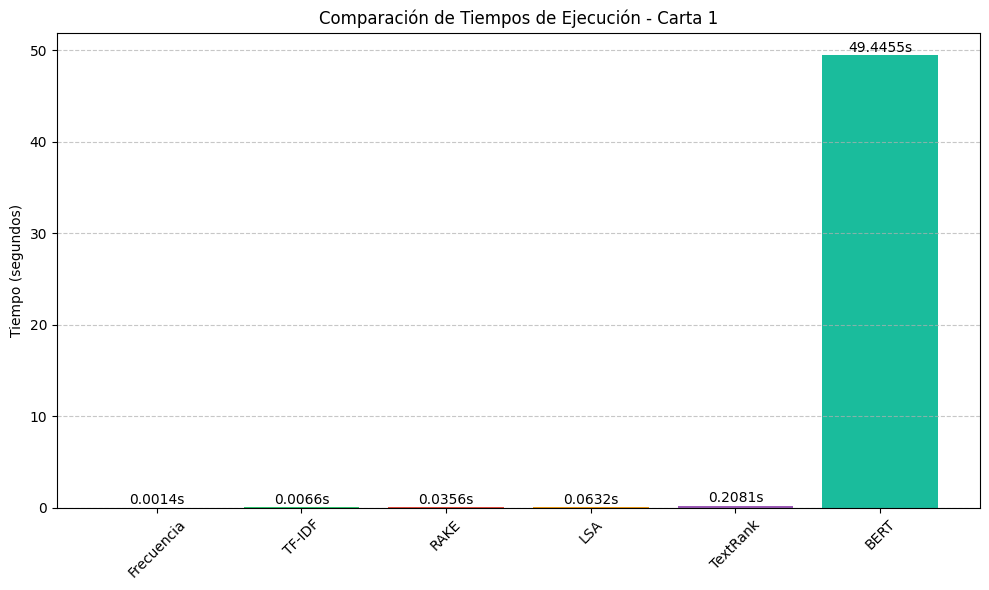

Comparación de tiempos de ejecución para Carta 2:


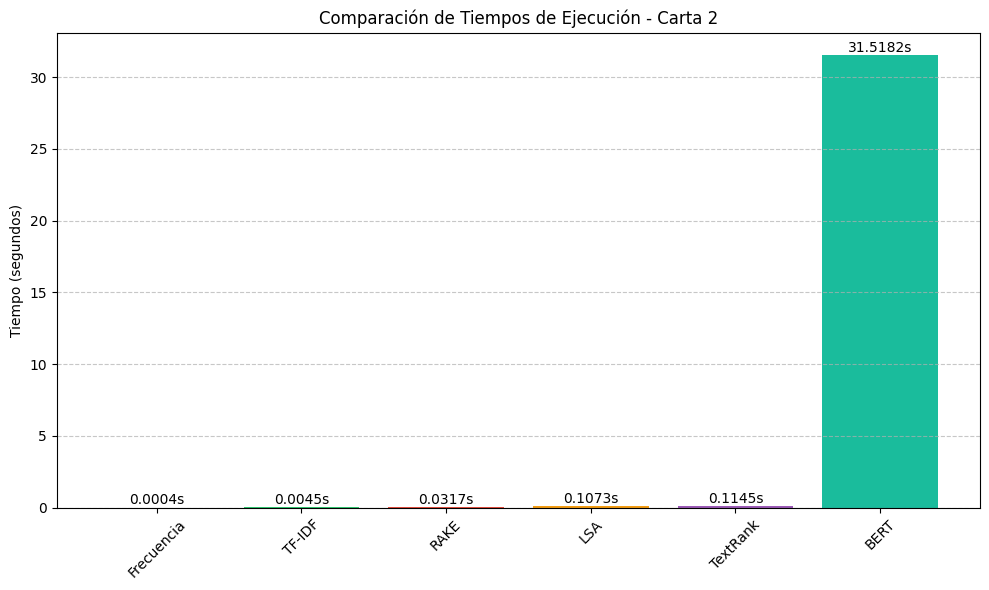

Comparación de tiempos de ejecución para Carta 3:


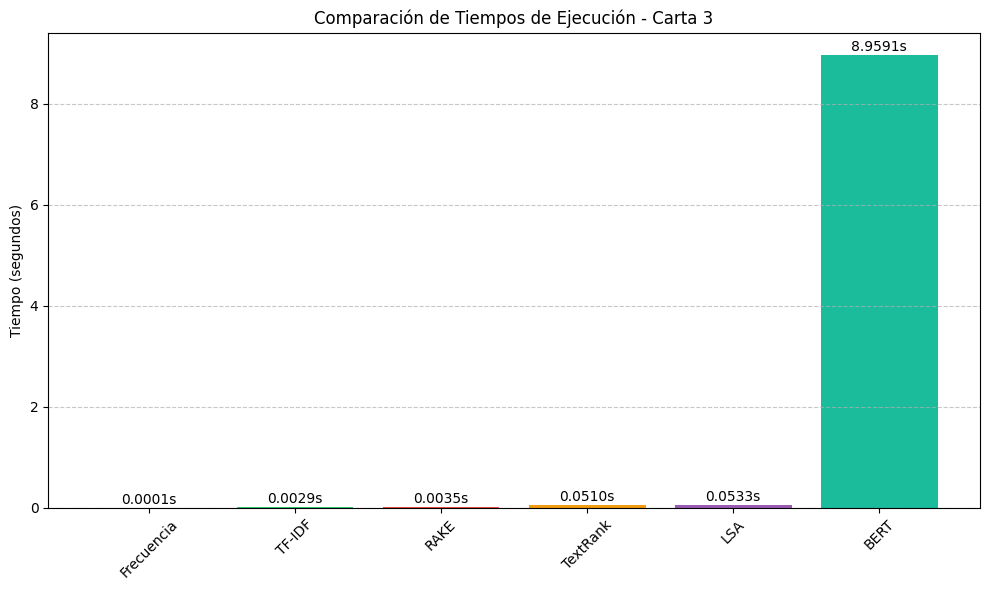

In [20]:
algoritmos = ["TF-IDF", "Frecuencia", "RAKE", "TextRank", "LSA", "BERT"]

# Tiempos para carta 1
tiempos_carta1 = [tiempo_tfidf_1, tiempo_freq_1, tiempo_rake_1,
                 tiempo_textrank_1, tiempo_lsa_1, tiempo_bert_1]

# Tiempos para carta 2
tiempos_carta2 = [tiempo_tfidf_2, tiempo_freq_2, tiempo_rake_2,
                 tiempo_textrank_2, tiempo_lsa_2, tiempo_bert_2]

# Tiempos para carta 3
tiempos_carta3 = [tiempo_tfidf_3, tiempo_freq_3, tiempo_rake_3,
                 tiempo_textrank_3, tiempo_lsa_3, tiempo_bert_3]

# Generamos los gráficos
print("Comparación de tiempos de ejecución para Carta 1:")
graficar_tiempos(algoritmos, tiempos_carta1, "Carta 1")

print("Comparación de tiempos de ejecución para Carta 2:")
graficar_tiempos(algoritmos, tiempos_carta2, "Carta 2")

print("Comparación de tiempos de ejecución para Carta 3:")
graficar_tiempos(algoritmos, tiempos_carta3, "Carta 3")

## 5. Análisis y Conclusiones

### 5.1 Análisis de Resultados

En esta práctica, se implementaron y evaluaron seis algoritmos diferentes para la tarea de resumen automático extractivo de texto, aplicados a las tres primeras cartas del libro "Frankenstein". Cada algoritmo seleccionó las cuatro oraciones consideradas más representativas de cada carta individualmente. A continuación, se analiza el desempeño y los resultados de cada método:

**Análisis Cualitativo de los Resúmenes:**

Todos los algoritmos generaron resúmenes extrayendo oraciones completas del texto original. Sin embargo, la selección de estas oraciones varió, reflejando los diferentes enfoques subyacentes de cada técnica:

1.  **TF-IDF y Frecuencia Normalizada:** Estos métodos, ambos basados en la frecuencia de términos (con TF-IDF ponderando además la rareza del término en el corpus implícito de oraciones), tendieron a producir resúmenes muy similares entre sí, especialmente en textos más cortos como la Carta 3, donde los resúmenes fueron idénticos. Se enfocaron en oraciones que contenían palabras clave repetidas frecuentemente tras la normalización (eliminación de stopwords, etc.). Estos resúmenes capturan bien los temas centrales explícitamente mencionados (el viaje, la falta de un amigo, el propósito de la expedición, las condiciones del viaje). Son efectivos para identificar los puntos principales basados en prominencia léxica.
2.  **RAKE:** Este algoritmo, diseñado para extraer frases clave basadas en patrones de co-ocurrencia, también produjo resúmenes similares a los métodos de frecuencia para las Cartas 1 y 3. En la Carta 2, mostró una tendencia a enfocarse más en la anécdota del capitán del barco, posiblemente porque contenía frases clave distintivas según su métrica. Su rendimiento parece bueno para identificar frases temáticas importantes.
3.  **TextRank:** Basado en un enfoque de grafos similar a PageRank, TextRank identifica oraciones "centrales" por su similitud con otras oraciones importantes. Los resúmenes generados a menudo capturaban bien la estructura temática y narrativa. Por ejemplo, en la Carta 2, seleccionó tanto la falta de amigo como la fascinación por la exploración, ofreciendo una visión equilibrada. En la Carta 3, incluyó la oración sobre la determinación y el triunfo, añadiendo un matiz de tono que otros métodos no seleccionaron.
4.  **LSA (Latent Semantic Analysis):** Este método utiliza la descomposición semántica latente para encontrar las oraciones que mejor representan los "conceptos" subyacentes del texto. Los resúmenes de LSA a veces diferían notablemente de los basados en frecuencia. En la Carta 1, seleccionó oraciones sobre sueños pasados y la aversión a morir en el camino, que podrían considerarse menos centrales que las seleccionadas por TF-IDF. En la Carta 2, se centró fuertemente en el tema de la soledad y el anhelo de compañía. Esto sugiere que LSA puede capturar dimensiones temáticas más sutiles, aunque a veces a costa de no seleccionar las oraciones más explícitamente representativas del contenido superficial.
5.  **BERT (bert-extractive-summarizer):** Utilizando un modelo Transformer pre-entrenado, BERT tiene una comprensión contextual profunda del lenguaje. Los resúmenes generados por BERT a menudo parecían capturar bien el flujo narrativo y los puntos clave con buen contexto semántico. Seleccionó oraciones que reflejaban momentos importantes o cambios de tono (por ejemplo, la dedicatoria a la empresa en la Carta 1, el misterio del alma en la Carta 2, las preguntas retóricas finales en la Carta 3). Cualitativamente, sus resúmenes parecen robustos, aunque la selección exacta puede ser menos predecible que en métodos más simples.

**Análisis Cuantitativo de Tiempos de Ejecución:**

Los gráficos generados muestran claras diferencias en la eficiencia computacional de los algoritmos:

*   **BERT:** Fue consistentemente, y por un margen muy amplio, el algoritmo más lento en las tres cartas. Su tiempo de ejecución fue de órdenes de magnitud mayor (decenas de segundos para las cartas 1 y 2, varios segundos para la corta carta 3) que los otros métodos. Esto es esperado, dada la complejidad computacional de los modelos Transformer. El tiempo también fue sensible a la longitud del texto, disminuyendo notablemente para la Carta 3.
*   **Métodos Rápidos:** Los otros cinco algoritmos (TF-IDF, Frecuencia, RAKE, TextRank, LSA) fueron significativamente más rápidos, ejecutándose generalmente en fracciones de segundo.
    *   El método de **Frecuencia Normalizada** fue el más rápido consistentemente, a menudo completando la tarea en milisegundos. Su simplicidad (conteo y suma de frecuencias) lo hace extremadamente eficiente.
    *   **TF-IDF** y **RAKE** también fueron muy rápidos, usualmente completando en pocos milisegundos.
    *   **TextRank** y **LSA (vía Sumy)** mostraron tiempos ligeramente mayores que los anteriores, pero aún muy rápidos (generalmente por debajo de 0.2 segundos). Esto se debe a los cálculos adicionales requeridos (ranking de grafos para TextRank, SVD para LSA).

**Trade-off Rendimiento vs. Calidad:** Existe un claro trade-off. BERT, el más lento, aprovecha modelos de lenguaje avanzados que potencialmente pueden generar resúmenes semánticamente más ricos o contextualmente más apropiados. Los métodos más rápidos, especialmente los basados en frecuencia, son computacionalmente baratos pero pueden basarse más en la prominencia léxica superficial que en el significado profundo. TextRank y LSA se sitúan en un punto intermedio, ofreciendo enfoques más sofisticados que la simple frecuencia, pero sin el coste computacional de BERT.

### 5.2 Conclusiones Finales

La práctica demostró la aplicación de diversas técnicas de resumen automático extractivo, desde métodos clásicos basados en frecuencia hasta enfoques semánticos y basados en Transformers.

*   Los métodos basados en **frecuencia (TF-IDF, Frecuencia Normalizada)** y **frases clave (RAKE)** son extremadamente rápidos y efectivos para identificar los temas más explícitamente discutidos en el texto. Son opciones sólidas cuando la velocidad es primordial.
*   **TextRank** y **LSA** ofrecen enfoques alternativos (centralidad en grafos y semántica latente, respectivamente) que pueden capturar aspectos diferentes del texto con una eficiencia computacional aún muy buena.
*   **BERT** representa el estado del arte en comprensión del lenguaje, ofreciendo resúmenes potencialmente más ricos contextualmente, pero a un costo computacional significativamente mayor. Su uso estaría justificado en escenarios donde la calidad del resumen es crítica y los recursos computacionales (tiempo y hardware) no son una limitación principal.

La elección del algoritmo de resumen dependerá fuertemente de los requisitos específicos de la aplicación, balanceando la necesidad de velocidad, recursos computacionales y la calidad o tipo de información deseada en el resumen. Cabe destacar que la evaluación de la "calidad" del resumen es inherentemente subjetiva en este contexto y podría formalizarse utilizando métricas como ROUGE si se dispusiera de resúmenes de referencia ("gold standard"). Finalmente, todos los métodos implementados son de naturaleza *extractiva*, lo que significa que pueden sufrir de falta de coherencia o flujo al concatenar oraciones originalmente no contiguas.